# Preparing Gibbs Clustering Input and Running Monoallelic Dataset Benchmark
### Libraries

In [2]:
#analysis
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt

#logging
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

### Class Dataset
One can generate a dataset and analyze or visualize parts of it.
You can only add elements to dataset once.
Analysis works on ABC loci.

In [3]:
class DataSet:
    def __init__(self):
        """
        Initializes the dataset object.
        The mode is set to ABC by default meaning to only look at MHC alleles starting with A, B or C (not E, G).

    
        """
        self.dataframe = pd.DataFrame({'Allele': [], 'Peptide': [], 'Source': []})
        self.mode = "ABC"

    def get_dataframe(self):
        return self.dataframe

    def add_dfs_to_dataset(self, paths, sources, seps):
        """
        Adds dataframes to dataset object, assumes datsets are annotated with Allele(seperator)Peptide.
        Gets you a datset with Allele Peptide and Source column

        Args:
            paths (list): list of paths to dataframes
            sources (list): list of Sources of dataframes (if you want to annotate where the data comes from)
            seps (list): list of seperators of dataframes
        
        """
        assert len(paths) == len(sources) == len(seps)
        assert len(self.dataframe) == 0
        assert len(paths) > 0
        
        df_list = []
        for i,path in enumerate(paths):
            df = pd.read_csv(path, sep=seps[i])
            #remove duplicates input df
            df = df.drop_duplicates(subset=['Allele','Peptide'], keep='first')
            df['Source'] = sources[i]
            df_list.append(df)
        joined_df = pd.concat(df_list)
        joined_df = joined_df.drop_duplicates(subset=['Allele','Peptide'], keep='first')
        joined_df = joined_df[joined_df['Allele'].str.startswith('A') | joined_df['Allele'].str.startswith('B') | joined_df['Allele'].str.startswith('C')]
        self.dataframe = joined_df

    
    def cleanup_peptide(self):
        """
        removes peptide annotation: AYSSY(Oxidation)KIIK -> AYSSYKIIK.

        """
        self.dataframe["Peptide"] = self.dataframe["Peptide"].str.replace(r"\(.*\)","", regex=True)

    def visualize_available_data_per_allele_letter(self, allele_letter, color="orange"):
        """
        Visualizes the number of sequences per allele starting with allele_letter.

        """
        dataframe = self.dataframe.copy()
        dataframe = dataframe[dataframe['Allele'].str.startswith(allele_letter)]
        allele_sequences = dataframe.groupby('Allele')['Peptide'].apply(list).reset_index()
        print(f"There are {len(allele_sequences['Allele'])} alleles starting with {allele_letter}.")
        plt.bar(allele_sequences['Allele'], allele_sequences['Peptide'].apply(len) ,color=color)
        plt.xlabel('Allele')
        plt.ylabel('Number of Sequences')
        plt.title('Distribution of Alleles in Sequence Allele Pairs')
        plt.xticks(allele_sequences['Allele'], allele_sequences['Allele'] , rotation=90)
        plt.show()
    
    def analyze_specificity_of_peptides(self):
        """
        After dataframe is added, we can analyze the specficifity of the peptides for the alleles.

                """
        dataframe = self.dataframe.copy()
        g = dataframe.groupby('Peptide')['Allele'].apply(list).reset_index()
        g['Allele'] = g['Allele'].apply(lambda x: {'A': ''.join(x).count('A'), 'B': ''.join(x).count('B'), 'C': ''.join(x).count('C')})
        #drop all peptides that are not allele specific
        peptides_df_allele_specific = g[g['Allele'].apply(_check_dict_allele_specific)]
        allele_specific_freq = {'A':0, 'B':0, 'C':0}
        #count how many entries in Allele column of df start with 'A' 'B' and 'C' and increase value in dict
        for allele in peptides_df_allele_specific['Allele']:
            if allele['A']==1:
                allele_specific_freq['A'] += 1
            elif allele['B']==1:
                allele_specific_freq['B'] += 1
            elif allele['C']==1:
                allele_specific_freq['C'] += 1
        amount_a = allele_specific_freq['A']
        amount_b = allele_specific_freq['B']
        amount_c = allele_specific_freq['C']
        plt.bar(['A','B','C'], [amount_a,amount_b,amount_c], color="green")
        plt.xlabel('Locus')
        plt.ylabel('Sequences')
        #scaled to 360000
        plt.ylim((0,380000))
        plt.show()

    
    def visualize_allele_groups_quantitatively(self, title='Distribution of Alleles in all Donors'):
        """
        Visualize allele groups (implemented for A, B, C loci).

        """
        dataframe = self.dataframe.copy()
        dataframe = dataframe[dataframe['Allele'].str.startswith('A') | dataframe['Allele'].str.startswith('B') | dataframe['Allele'].str.startswith('C')]
        x_axis = list(self.mode)
        colors = ["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF"]
        colors = colors[:len(x_axis)]
        dataframe["Allele"] = [i[0] for i in dataframe["Allele"]]
        allele_sequences = dataframe.groupby('Allele')['Peptide'].apply(list).reset_index()
        plt.bar(allele_sequences['Allele'], allele_sequences['Peptide'].apply(len), color="green")
        plt.xlabel('Locus')
        plt.ylabel('Sequences')
        plt.ylim((0,380000))
        #plt.title(title)
        plt.show()

def _check_dict_allele_specific(dict):
    """
    Checks if dictionary belongs to an allele specific peptide. There needs to be exactly one 1 value and two 0 values in the dictionary.

    Args:
        dict (dict): dictionary with allele counts
    
    Returns:
        bool: True if dict belongs to allele specific peptide, False otherwise

    """
    return sum(1 for value in dict.values() if value == 0) == 2 and sum(1 for value in dict.values() if value == 1) == 1



# Datasets

In [4]:
all_peptide_allele_data = DataSet()
all_peptide_allele_data.add_dfs_to_dataset(paths=['../../../DATA/data_readout_final/1_readout_data_mhcmotifatlas_classI_MS_Peptides_all_peptides.csv', 
                                    '../../../DATA/data_readout_final/2_1readout_data_MSV000084172_2016.csv',
                                    '../../../DATA/data_readout_final/2_2readout_data_MSV000084172_2017.csv',
                                    '../../../DATA/data_readout_final/3_1readout_data_MSV000090323_batch12.csv',
                                    '../../../DATA/data_readout_final/3_2readout_data_MSV000090323_batch15.csv',
                                    '../../../DATA/data_readout_final/4_readout_data_PXD009531.csv',
                                    '../../../DATA/data_readout_final/5_1breadout_data_netmhcpan_binder.csv',
                                    '../../../DATA/data_readout_final/mhcflurry_data.csv'], 
                            sources=['mhcmotifatlas',
                                    'msv84172_2016',
                                    'msv84172_2017',
                                    'msv90323_12',
                                    'msv90323_15',
                                    'pxd9531',
                                    'netmhcpan_binder',
                                    'mhcflurry'],
                            seps=['\t']*8)
all_peptide_allele_data.cleanup_peptide()

# Visualization and Analysis of datasets

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


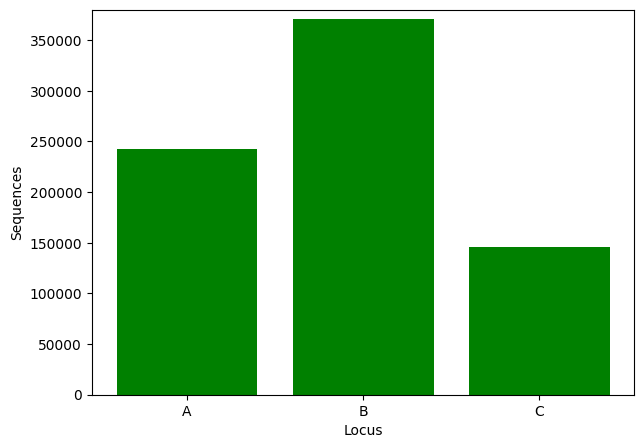

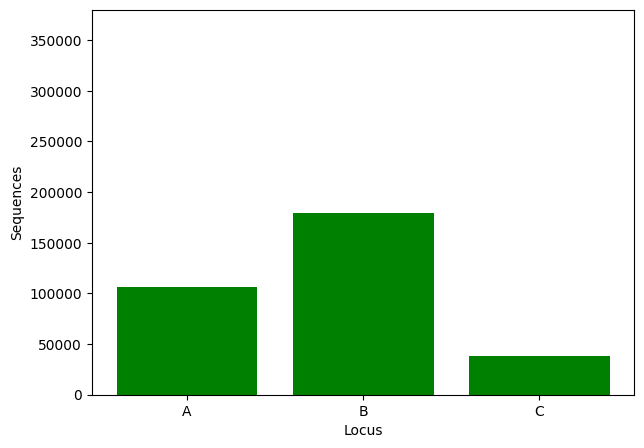

In [5]:
plt.rcParams["figure.figsize"] = (7,5)

all_peptide_allele_data.visualize_allele_groups_quantitatively()
all_peptide_allele_data.analyze_specificity_of_peptides()

### We will work with this monoallelic dataset for all approaches:

In [6]:
analysis = all_peptide_allele_data.get_dataframe().copy()
display(analysis.head())

#pipe to csv
analysis = analysis.drop(columns=['Source'])
analysis.to_csv('../../../DATA/data_readout_final/analysis_all_peptides.csv', sep='\t', index=False)

analysis = analysis.groupby('Allele')['Peptide'].apply(list).reset_index()
analysis['amount of peptides'] = analysis['Peptide'].apply(len)
analysis = analysis.drop(columns=['Peptide'])

#change string in Allele column to only contain the first 3 letters and collect them in set 
alleles = analysis['Allele'].str[:3]
alleles = set(alleles)
alleles_a = [allele for allele in alleles if allele.startswith('A')]
alleles_b = [allele for allele in alleles if allele.startswith('B')]
alleles_c = [allele for allele in alleles if allele.startswith('C')]
print(f'There are {len(alleles_a)} alleles in the dataset starting with A: {alleles_a}')
print(f'There are {len(alleles_b)} alleles in the dataset starting with B: {alleles_b}')
print(f'There are {len(alleles_c)} alleles in the dataset starting with C: {alleles_c}')


print(analysis)
#print lowest and highest amount of peptides
print(analysis[analysis['amount of peptides'] == analysis['amount of peptides'].min()])
print(analysis[analysis['amount of peptides'] == analysis['amount of peptides'].max()])

,Allele,Peptide,Source
0,A0101,ALDGRETD,mhcmotifatlas
1,A0101,ASDSGKYL,mhcmotifatlas
2,A0101,AVDPTSGQ,mhcmotifatlas
3,A0101,DISQTSKY,mhcmotifatlas
4,A0101,DSDINNRL,mhcmotifatlas


There are 21 alleles in the dataset starting with A: ['A03', 'A80', 'A02', 'A69', 'A33', 'A24', 'A31', 'All', 'A11', 'A34', 'A23', 'A01', 'A36', 'A68', 'A32', 'A25', 'A29', 'A74', 'A66', 'A26', 'A30']
There are 33 alleles in the dataset starting with B: ['B44', 'B38', 'B14', 'B54', 'B41', 'B81', 'B58', 'B52', 'B18', 'B73', 'B37', 'B47', 'B46', 'B56', 'B13', 'B27', 'B53', 'B08', 'B51', 'B55', 'B49', 'B07', 'B15', 'B83', 'B42', 'B45', 'B35', 'B50', 'B39', 'B40', 'B57', 'B67', 'B48']
There are 13 alleles in the dataset starting with C: ['C04', 'C06', 'C12', 'C05', 'C16', 'C17', 'C15', 'C01', 'C08', 'C07', 'C03', 'C14', 'C02']
    Allele  amount of peptides
0    A0101               13976
1    A0103                   7
2    A0201               33365
3    A0202                6432
4    A0203                5895
..     ...                 ...
184  C1502                8879
185  C1505                 232
186  C1601               11191
187  C1602                 239
188  C1701                46

### Analysis not included in thesis: Allele specificity depending on MHC locus

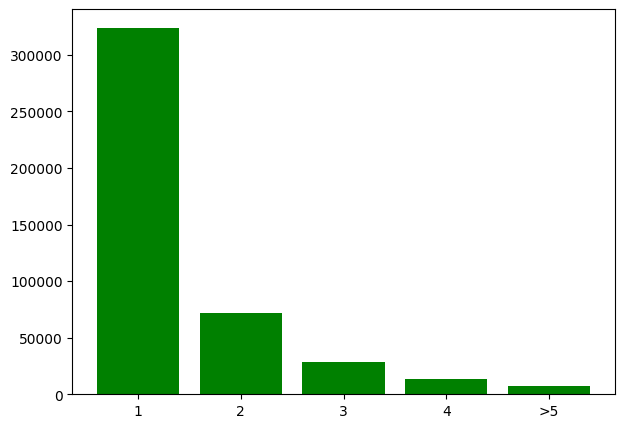

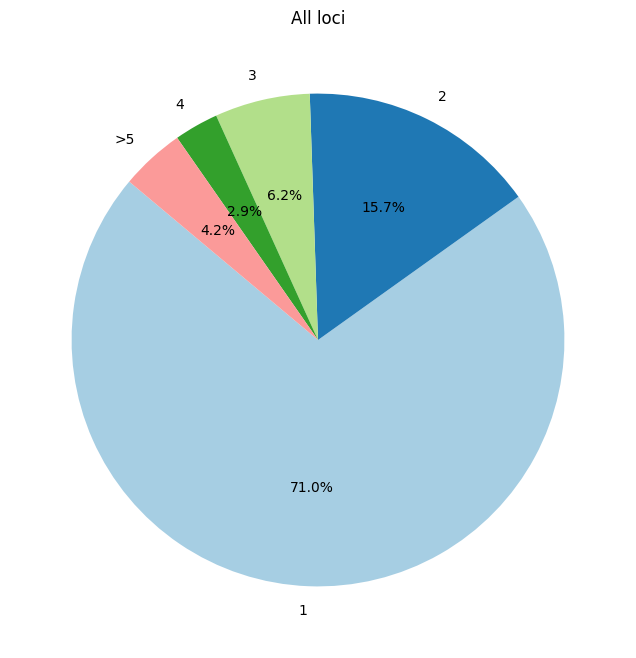

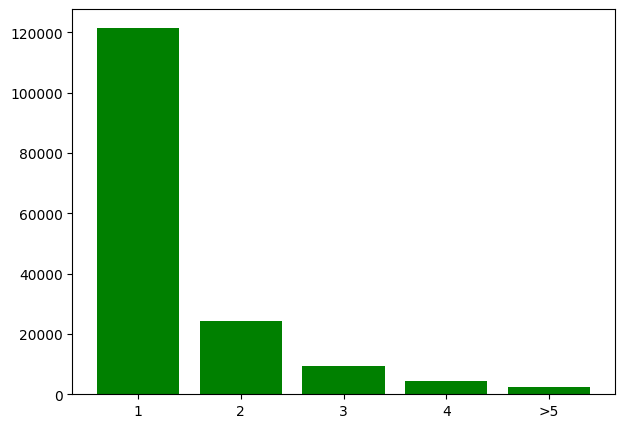

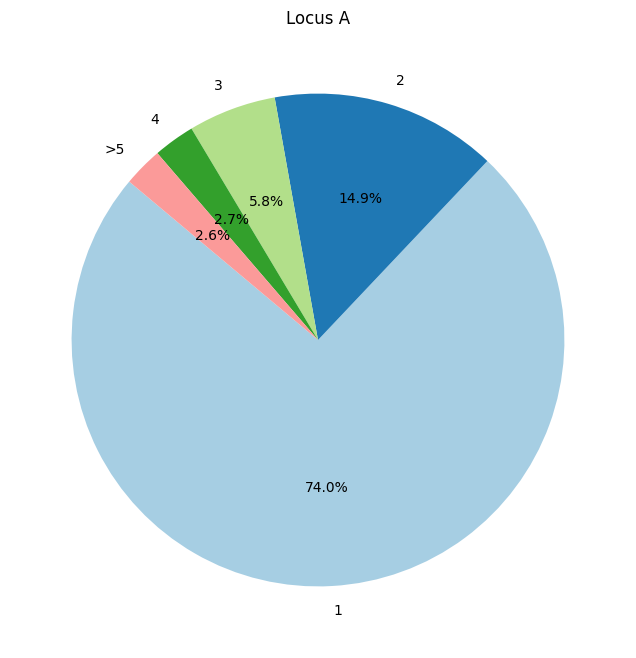

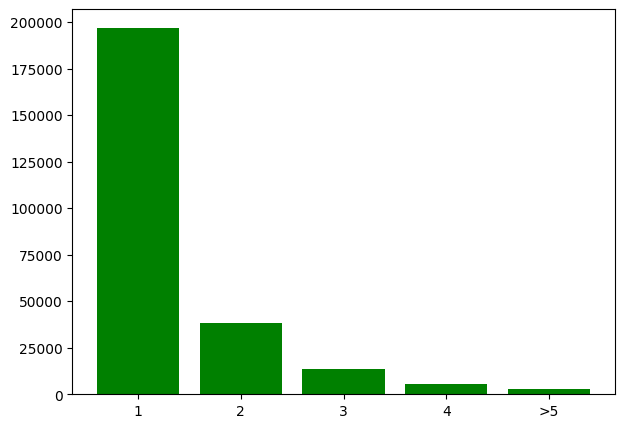

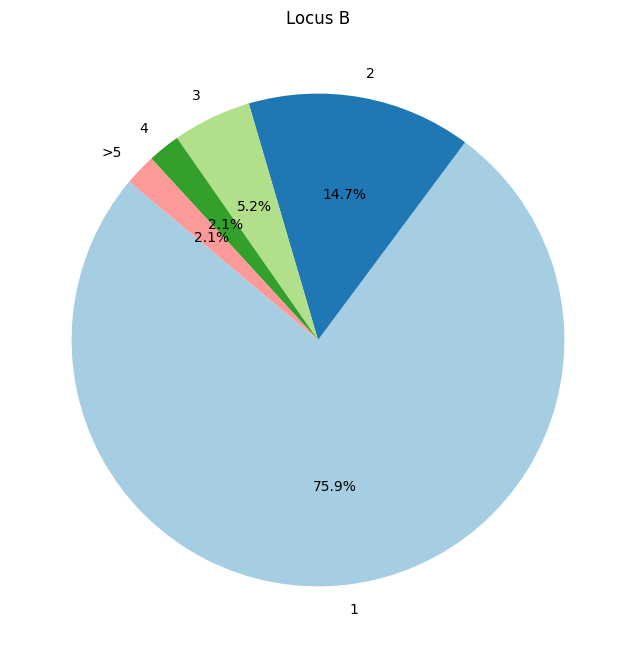

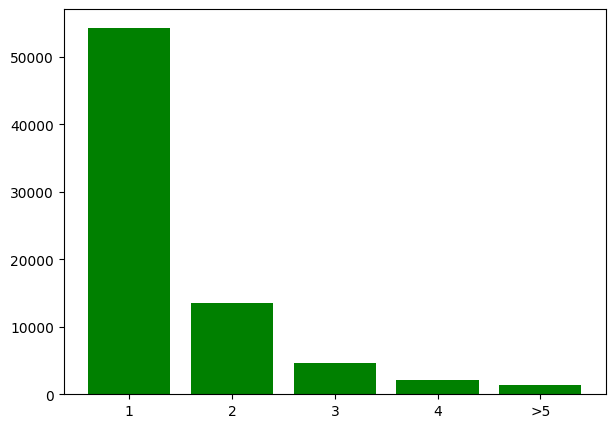

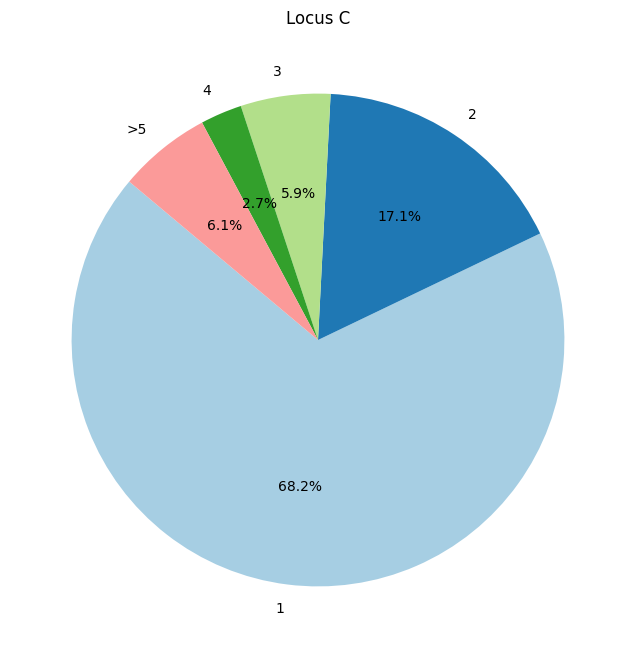

In [7]:
analyze_specificity_df = all_peptide_allele_data.get_dataframe().copy()
analyze_specificity_df = analyze_specificity_df.groupby('Peptide')['Allele'].apply(list).reset_index()
 #convert length of list into number 
analyze_specificity_df['Allele'] = analyze_specificity_df['Allele'].apply(len)
#group the peptides by the amount of alleles they bind to
analyze_specificity_df = analyze_specificity_df.groupby('Allele')['Peptide'].apply(list).reset_index()
#collect all greater 5 in one group
analyze_specificity_df['Allele'] = analyze_specificity_df['Allele'].apply(lambda x: '>5' if x>4 else str(x))
#plot this
#set own labels

plt.bar(analyze_specificity_df['Allele'], analyze_specificity_df['Peptide'].apply(len), color="green")
pie_data = analyze_specificity_df.groupby('Allele')['Peptide'].apply(lambda x: len(sum(x, []))).reset_index(name='Count')
plt.figure(figsize=(8, 8))
plt.pie(pie_data['Count'], labels=pie_data['Allele'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('All loci')
plt.show()


#for A
analyze_specificity_dfA = all_peptide_allele_data.get_dataframe().copy()
analyze_specificity_dfA = analyze_specificity_dfA[analyze_specificity_dfA['Allele'].str.startswith('A')]
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Peptide')['Allele'].apply(list).reset_index()
 #convert length of list into number 
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(len)
#group the peptides by the amount of alleles they bind to
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(list).reset_index()
#collect all greater 5 in one group
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(lambda x: '>5' if x>4 else str(x))


plt.bar(analyze_specificity_dfA['Allele'], analyze_specificity_dfA['Peptide'].apply(len), color="green")
pie_data = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(lambda x: len(sum(x, []))).reset_index(name='Count')
plt.figure(figsize=(8, 8))
plt.pie(pie_data['Count'], labels=pie_data['Allele'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Locus A')
plt.show()

analyze_specificity_dfA = all_peptide_allele_data.get_dataframe().copy()
analyze_specificity_dfA = analyze_specificity_dfA[analyze_specificity_dfA['Allele'].str.startswith('B')]
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Peptide')['Allele'].apply(list).reset_index()
 #convert length of list into number 
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(len)
#group the peptides by the amount of alleles they bind to
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(list).reset_index()
#collect all greater 5 in one group
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(lambda x: '>5' if x>4 else str(x))
#plot this
#set own labels

plt.bar(analyze_specificity_dfA['Allele'], analyze_specificity_dfA['Peptide'].apply(len), color="green")
pie_data = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(lambda x: len(sum(x, []))).reset_index(name='Count')
plt.figure(figsize=(8, 8))
plt.pie(pie_data['Count'], labels=pie_data['Allele'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Locus B')
plt.show()

analyze_specificity_dfA = all_peptide_allele_data.get_dataframe().copy()
analyze_specificity_dfA = analyze_specificity_dfA[analyze_specificity_dfA['Allele'].str.startswith('C')]
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Peptide')['Allele'].apply(list).reset_index()
 #convert length of list into number 
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(len)
#group the peptides by the amount of alleles they bind to
analyze_specificity_dfA = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(list).reset_index()
#collect all greater 5 in one group
analyze_specificity_dfA['Allele'] = analyze_specificity_dfA['Allele'].apply(lambda x: '>5' if x>4 else str(x))
#plot this
#set own labels

plt.bar(analyze_specificity_dfA['Allele'], analyze_specificity_dfA['Peptide'].apply(len), color="green")
pie_data = analyze_specificity_dfA.groupby('Allele')['Peptide'].apply(lambda x: len(sum(x, []))).reset_index(name='Count')
plt.figure(figsize=(8, 8))
plt.pie(pie_data['Count'], labels=pie_data['Allele'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Locus C')
plt.show()

